In [83]:

import time
import re
from datetime import datetime
import os
import scipy
from scipy.signal import savgol_filter
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

#!pip install uiautomation
#!pip install pywinauto
#!pip install nidaqmx
#!pip install matplotlib
#!pip install scipy
#!pip install -U pyautoit

import autoit
from pywinauto.application import Application
import pandas as pd
import time  
import re
from datetime import datetime
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

app = Application(backend="uia") .connect(title="AfterMath 1.6.10519")

In [84]:

class Pine:
    
    def __init__(self,app=None):
        if app is None:
            print('Finding App')
            self.app = Application(backend="uia") .connect(title="AfterMath 1.6.10519")
        else :
            self.app = app
 
        self.treeviewItems, self.panes = self.findPanes()
        
        
    def findPerform(self,control):
        for c in control.children():
            #print(c)
            if c.window_text()=='Perform':
                print('found')
                return c
        for c in control.children():
            print(c)
            fcn = c.friendlyclassname
            if fcn!='TabControl' and fcn!='Pane':
                tab = self.findPerform(c)
            else :
                tab = None
            if tab is not None:
                return tab
        return None
        
    def findTab(self,control):
        for c in control.children():
            print(c)
            if c.friendlyclassname=='TabControl':
                return c
        for c in control.children():
            tab = self.findTab(c)
            if tab is not None:
                return tab
        return None

    def findPanes(self):
        treeviewItems =[]
        panes = []
        for win in self.app.windows():
            for child in win.descendants():
                if 'TreeItemWrapper' in f'{child}':
                    treeviewItems.append(child)
                if "Pane"==child.friendly_class_name():
                    panes.append(child)
        return treeviewItems, panes

    def findSweeps(self,paax_archive):
        self.archives = []            
        self.activeArchive = None
        MuxCVSweepK1=None
        MuxCVSweepK2=None
        
        for tvi in self.treeviewItems:
            info = f'{tvi}'
            if (paax_archive in info) and ('.paax' in info):
                self.archives.append(tvi)
                if not tvi.is_expanded():
                    tvi.expand()
                    time.sleep(.5)
                    
                    
                paaxItems = []            
                for child in tvi.descendants():
                    paaxItems.append(child)
                    
                
                for pi in paaxItems:
                    if pi.window_text()=='MuxCVSweep Parameters':
                        MuxCVSweepK1 = pi
                    if pi.window_text()=='MuxK2Sweep Parameters':
                        MuxCVSweepK2 = pi
                
                if MuxCVSweepK1!=None:
                    self.activeArchive = tvi
                    break 
                tvi.collapse()
                
        self.MuxCVSweepK1, self.MuxCVSweepK2 = MuxCVSweepK1, MuxCVSweepK2 
        
    def RenameData(self,oldName,newName):
        for child in self.activeArchive.children():
            if (child.window_text())==oldName:
                child.select()
                child.expand()
                
                child.ensure_visible()
                child.right_click_input()
        
                self.app.top_window().type_keys('R')
                self.app.top_window().type_keys(newName ) 

                break     
        child.collapse()
        return child
            
            

    def MUXCVSweepK1(self,experimentName, inital_K1_mV ,upper_K1_mV ,lower_K1_mV ,final_K1_mV, segments, sweep_rate_mv_s ,K2_mV, range_K1_nA,range_K2_nA, rising=True):
        self.MuxCVSweepK1.select() 
        time.sleep(.5)
        cv_params_pane        =None
        while cv_params_pane is None:
            time.sleep(.25)
            for pane in self.panes:
                if 'MuxCVSweep Parameters' in pane.window_text() and cv_params_pane is None :
                    cv_params_tab=self.findTab(pane) 
                    if cv_params_tab != None:
                        cv_params_pane = pane 
                        cv_params_tab.select(1)
                        print('found - MuxCVSweep Parameters')
                        break
        
        edits ={}

        for child in cv_params_tab.children() :
            print(child)
            if child.friendly_class_name()=='Pane':
                for gchild in child.descendants():
                    key =f"{ gchild. parent().automation_id()}+{gchild.automation_id()}"
                    key = key.replace('userNumericTextboxSIControl','').replace("userNumericComboboxSI","").replace("comboBoxSI","").replace("groupBox","") \
                        .replace("cb","").replace("radioButton","").replace("textBoxNum","").replace("textBoxValue","tb").strip()
                    if key.startswith('comboBoxValue'):
                        key = gchild.parent().parent(). parent().window_text() +key 
                    if gchild.friendly_class_name()=='Edit':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='ComboBox':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='Button':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='RadioButton':
                        edits[key]=(gchild)
                break 

        performButton = self.findPerform(cv_params_pane) 
        edits["+Segments"].set_edit_text(f"{segments}")
        
        edits["InitialSignal+tb"].set_edit_text(f"{inital_K1_mV}")
        edits["InitialSignal+Unit"].select(1)
        
        if rising:
            edits["+InitialDirectionRising"].click()
        else:
            edits["+InitialDirectionFalling"].click()
        
        edits["UpperSignal+tb"].set_edit_text(f"{upper_K1_mV}")
        edits["UpperSignal+Unit"].select(1)
        
        edits["LowerSignal+tb"].set_edit_text(f"{lower_K1_mV}")
        edits["LowerSignal+Unit"].select(1)
        
        edits["FinalSignal+tb"].set_edit_text(f"{final_K1_mV}")
        edits["FinalSignal+Unit"].select(1)
        
        edits["+tb"].set_edit_text(f"{sweep_rate_mv_s}")
        edits["+Unit"].select(1)
        
        edits["signal+tb"].set_edit_text(f"{K2_mV}")
        edits["signal+Unit"].select(1)
        
        edits["Electrode range (K1)comboBoxValue+1001"].set_edit_text(f"{range_K1_nA}")
        edits["Electrode range (K2)comboBoxValue+1001"].set_edit_text(f"{range_K2_nA}")
        
        performButton.set_focus()
        performButton.click_input()

        return self.WaitForCvFinish( experimentName)
        
    def WaitForCvFinish(self,experimentName):
        cv_Status_pane        =None
        while cv_Status_pane is None:
            time.sleep(.25)
            for pane in self. panes:
                if 'Instrument status' == pane.window_text().strip() :
                    cv_Status_pane=pane
                    print('found - Instrument status')
                    break

        time.sleep(.25)
        def findExperiment(control):
            for c in control.children():
                cc=f"{c}"
                if c.window_text().startswith('Experiment in progress'):
                    return c
            for c in control.children():
                tab = findExperiment(c)
                if tab is not None:
                    return tab
            return None

        c=findExperiment(cv_Status_pane)
        texperimentname=c.window_text().replace("Experiment in progress - ","").strip()  


        cv_Status_pane        =None
        while cv_Status_pane is None:
            time.sleep(.25)
            for pane in self.panes:
                if 'Voltammogram' == pane.window_text().strip() :
                    cv_Status_pane=pane
                    print('found - Voltammogram')
                    break

        treeItem = self.RenameData(texperimentname,experimentName) 
        
        return treeItem
        

    def MUXCVSweepK2(self, experimentName, inital_K2_mV ,upper_K2_mV ,lower_K2_mV ,final_K2_mV, segments, sweep_rate_mv_s ,K1_mV, range_K1_nA,range_K2_nA, rising=True):
        self.MuxCVSweepK2_tvi.select() 
        time.sleep(.5)
        cv_params_pane        =None
        while cv_params_pane is None:
            time.sleep(.25)
            for pane in self.panes:
                if 'MuxK2Sweep Parameters' in pane.window_text() and cv_params_pane is None :
                    cv_params_tab=self.findTab(pane) 
                    if cv_params_tab != None:
                        cv_params_pane = pane 
                        cv_params_tab.select(1)
                        print('found - MuxCVSweep Parameters')
                        break
        
        edits ={}

        for child in cv_params_tab.children() :
            print(child)
            if child.friendly_class_name()=='Pane':
                for gchild in child.descendants():
                    key =f"{ gchild. parent().automation_id()}+{gchild.automation_id()}"
                    key = key.replace('userNumericTextboxSIControl','').replace("userNumericComboboxSI","").replace("comboBoxSI","").replace("groupBox","") \
                        .replace("cb","").replace("radioButton","").replace("textBoxNum","").replace("textBoxValue","tb").strip()
                    
                    if key.startswith('comboBoxValue'):
                        key = gchild.parent().parent(). parent().window_text() +key 
                    if gchild.friendly_class_name()=='Edit':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='ComboBox':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='Button':
                        edits[key]=(gchild)
                    if gchild.friendly_class_name()=='RadioButton':
                        edits[key]=(gchild)
                break 

        performButton = self.findPerform(cv_params_pane) 
        edits["+Segments"].set_edit_text(f"{segments}")
        
        edits["InitialSignal+tb"].set_edit_text(f"{inital_K2_mV}")
        edits["InitialSignal+Unit"].select(1)
        
        if rising:
            edits["+InitialDirectionRising"].click()
        else:
            edits["+InitialDirectionFalling"].click()
        
        edits["UpperSignal+tb"].set_edit_text(f"{upper_K2_mV}")
        edits["UpperSignal+Unit"].select(1)
        
        edits["LowerSignal+tb"].set_edit_text(f"{lower_K2_mV}")
        edits["LowerSignal+Unit"].select(1)
        
        edits["FinalSignal+tb"].set_edit_text(f"{final_K2_mV}")
        edits["FinalSignal+Unit"].select(1)
        
        edits["+tb"].set_edit_text(f"{sweep_rate_mv_s}")
        edits["+Unit"].select(1)
        
        edits["signal+tb"].set_edit_text(f"{K1_mV}")
        edits["signal+Unit"].select(1)
        
        edits["Electrode range (K1)comboBoxValue+1001"].set_edit_text(f"{range_K1_nA}")
        edits["Electrode range (K2)comboBoxValue+1001"].set_edit_text(f"{range_K2_nA}")
        
         
        performButton.set_focus()
        performButton.click_input()


        return self.WaitForCvFinish( experimentName)
        
                
    def ExportArchive(self,exportFolder):
        self.activeArchive.select()
        self.activeArchive.ensure_visible()
        self.activeArchive.right_click_input()
        self.app.top_window().type_keys('X')

        dlg = self.app['AfterMath 1.6.10519Dialog']

        for c in dlg.children():
            print(c)
            if c.window_text()=='AfterMath Quick Browser':
                for d in c.children():
                    print(d)
                    if d.window_text()=='Export':
                        d.click()
                        break
                    
        controls={}
        for c in dlg.children():
            if c.window_text()=='Export Options':
                for d in c.children():
                    #print(d.automation_id(), d.parent().window_text(), d.parent().automation_id())
                    #print(d.friendly_class_name())
                    if d.friendly_class_name()=='Edit' or d.friendly_class_name()=='RadioButton' or d.friendly_class_name()=='Button' or d.friendly_class_name()=='CheckBox':
                        key = f"{d.parent().automation_id()}+{d.automation_id()}"
                        controls[key]=d
                        print(key, d)
                    if d.friendly_class_name()!='ListBox':
                        for e in d.children():
        #                    print(e.automation_id(), e.parent().window_text(), e.parent().automation_id())
                            #print(e.friendly_class_name())
                            if e.friendly_class_name()=='Edit' or e.friendly_class_name()=='RadioButton' or e.friendly_class_name()=='Button' or e.friendly_class_name()=='CheckBox':
                                key = f"{e.parent().automation_id()}+{e.automation_id()}"
                                controls[key]=e
                                print(key, e)
                                
        controls["panel4+radBaseSI"].click()
        controls["panel1+radOverwrite"].click()
        controls["DAB_exporter+chkSegmentID"].click()
        controls["DAB_exporter+textSeparator"].set_edit_text(',')
        controls["DAB_exporter+txtDestinationPath"].set_edit_text(exportFolder)
        controls["DAB_exporter+btnExport"].click_input()           
        
        autoit.win_wait_active("Export Finished")
        autoit.control_click("Export Finished", "OK")               
        
        

    def loadAfterMath(self,folderPath):
        I1=pd.read_csv(os.path.join(folderPath,r'experiment\results\Measured Current (I1).csv'))
        I2=pd.read_csv(os.path.join(folderPath,r'experiment\results\Measured Current (I2).csv'))
        E1=pd.read_csv(os.path.join(folderPath,r'experiment\results\Measured Potential (E1).csv'))
        E2=pd.read_csv(os.path.join(folderPath,r'experiment\results\Measured Potential (E2).csv'))
        timeCol = I1['Time (s)']
        exp_df  = pd.DataFrame({'Time(s)':timeCol,'segment':I1['Segment']  })
        c=I1['Current (A)']
        c=np.interp(timeCol,I1['Time (s)'],c)
        exp_df[f"I1(A)"]=c 
        
        c=I2['Current (A)']
        c=np.interp(timeCol,I2['Time (s)'],c)
        exp_df[f"I2(A)"]=c 
        
        v=E1['Potential (V)']
        v=np.interp(timeCol,E1['Time (s)'],v)
        exp_df[f"E1(V)"]=v

        v=E2['Potential (V)']
        v=np.interp(timeCol,E2['Time (s)'],v)
        exp_df[f"E2(V)"]=v    
        return exp_df

    def loadExport(self,exportFolder,deleteTextFiles=False):
        experiments ={}
        for folder in os.listdir(exportFolder):
            #open csv files and then join then use the time column to join them into one dataframe
            #then save the dataframe as a csv file
            folderPath = os.path.join(exportFolder,folder)
            experiments[folder]=self.loadAfterMath(folderPath)
        if (deleteTextFiles) :
            for folder in os.listdir(exportFolder):
                folderPath = os.path.join(exportFolder,folder)
                for file in os.listdir(folderPath):
                    try :
                        os.remove(os.path.join(folderPath,file))
                    except:
                        pass
            #delete the folders
            for folder in os.listdir(exportFolder):
                try:
                    folderPath = os.path.join(exportFolder,folder)
                    os.rmdir(folderPath)
                except:
                    pass
            os.rmdir(exportFolder)
        return experiments         

    def CombineExperiment(self,experiments):
        keys = list(experiments.keys())
        timeStandard = experiments[keys[0]] ['Time(s)']
        wholeExperiment = pd.DataFrame({'Time(s)':timeStandard})
        for key in keys:
            #cycle through the columns and interpolate the data to the standard time column
            for col in experiments[key].columns:
                if col!='Time(s)':
                    c=experiments[key][col]
                    c=np.interp(timeStandard,experiments[key]['Time(s)'],c)
                    wholeExperiment[key + " " + col]=c

        return keys, wholeExperiment.copy()

pine=Pine(app)

In [3]:


archive = "RD_tests"

archives, activeArchive, MuxCVSweepK1, MuxCVSweepK2=findSweeps(treeviewItems,"RD_tests")


In [4]:
#MUXCVSweepK2(MuxCVSweepK2, inital_K2_mV =0,upper_K2_mV=0 ,lower_K2_mV=-300 ,final_K2_mV=0, segments=4, sweep_rate_mv_s=50 ,K1_mV=5,range_K1_nA=66,range_K2_nA=77, rising=False) 

In [78]:

currents     

{'DECV Experiment [2023-DEC-15 1629 #501]': 2859.6562261603463,
 'DECV Experiment [2023-DEC-15 1630 #502]': 197.2213740769107,
 'DECV Experiment [2023-DEC-15 1631 #503]': 2559.4470613447825,
 'DECV Experiment [2023-DEC-15 1632 #504]': 1339.5405637618592,
 'DECV Experiment [2023-DEC-15 1632 #505]': 800.3016797911042,
 'DECV Experiment [2023-DEC-15 1633 #506]': 3960.8354697452223,
 'DECV Experiment [2023-DEC-15 1634 #507]': 403.5677987557737,
 'DECV Experiment [2023-DEC-15 1635 #508]': 2088.2160216000357,
 'DECV Experiment [2023-DEC-15 1636 #509]': 574.0952560373219,
 'DECV Experiment [2023-DEC-15 1637 #510]': 0.23292716072401973,
 'DECV Experiment [2023-DEC-15 1637 #511]': 0.7127244860774034,
 'DECV Experiment [2023-DEC-15 1638 #512]': 0.3434511965045065,
 'DECV Experiment [2023-DEC-15 1639 #513]': 0.3228559324617562,
 'DECV Experiment [2023-DEC-15 1640 #514]': 0.23370476841078247,
 'DECV Experiment [2023-DEC-15 1641 #515]': 0.21010809887946724,
 'DECV Experiment [2023-DEC-15 1642 #516]

<AxesSubplot: xlabel='Time(s)'>

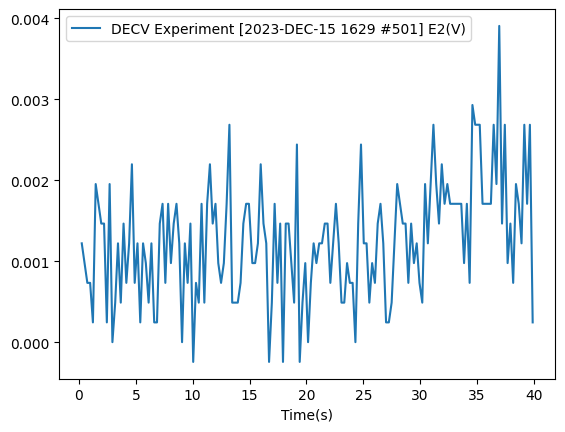

In [74]:

experiments.plot(x='Time(s)',y=expKeys[0] + " E2(V)")